In [1]:
from collections import defaultdict
import csv
from sklearn import linear_model
from sklearn.decomposition import PCA
import scipy
import scipy.optimize
import numpy
import random

In [2]:
def readCSV(path):
  f = open(path, 'rt')
  f.readline()
  for l in f:
    yield l.strip().split(',')
    
def calc_model_stats(pred,label):
    
    TP,FP,TN,FN = calc_metrics(pred,label)

    # print("Stats")
    # print(TP,FP,TN,FN)

    # print("Predict N: {} ({}%)".format(TN+FN,(TN+FN)/(TP+TN+FP+FN)))
    # print("Predict P: {} ({}%)".format(TP+FP,(TP+FP)/(TP+TN+FP+FN)))

    accuracy, TPR, TNR, BER = calc_error_rates(TP, FP, TN, FN)

    print("Accuracy: {}".format(accuracy))
    # print("TPR: {}".format(TPR))
    # print("TNR: {}".format(TNR))
    # print("BER: {}".format(BER))
    
    return
 
def calc_metrics(predictions, labels):
    # Calculate True positives, false positives, etc.

    TP_ = numpy.logical_and(predictions, labels)
    FP_ = numpy.logical_and(predictions, numpy.logical_not(labels))
    TN_ = numpy.logical_and(numpy.logical_not(predictions), numpy.logical_not(labels))
    FN_ = numpy.logical_and(numpy.logical_not(predictions), labels)

    TP=sum(TP_)
    FP=sum(FP_)
    TN=sum(TN_)
    FN=sum(FN_)
    
    return TP,FP,TN,FN

def calc_error_rates(TP, FP, TN, FN):
    # Calculate accuracy, TPR, TNR and BER
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP)
    BER = 1.0 - (TPR+TNR)/2
    
    return accuracy, TPR, TNR, BER


### Split Training Dataset into Train and Validation Datasets

In [18]:
dataset = []

for user,book,rating in readCSV("assignment1/train_Interactions.csv"):
  dataset.append([user,book,rating])

random.shuffle(dataset)

X = [values[0:2] for values in dataset]
y = [int(values[-1]) for values in dataset]

N = len(dataset)
Ntrain = 190001

Xtrain = X[:Ntrain]
Xvalid = X[Ntrain:]

ytrain = y[:Ntrain]
yvalid = y[Ntrain:]

print(N, len(ytrain),len(yvalid))

200000 190001 9999


### Adopt code from Workbook 4

In [19]:
ratingsPerUser = defaultdict(list)
ratingsPerItem = defaultdict(list)

for user,book,rating in dataset:
    ratingsPerUser[user].append(rating)
    ratingsPerItem[book].append(rating)

N = len(Xtrain)
nUsers = len(ratingsPerUser)
nItems = len(ratingsPerItem)
users = list(ratingsPerUser.keys())
items = list(ratingsPerItem.keys())

print (nUsers, nItems)
print (users[:3])
print (items[:3])

11357 7170
['u08619852', 'u69186302', 'u59611275']
['b45122162', 'b23498394', 'b39167058']


In [20]:
ratingMean = sum([y for y in ytrain])/len(ytrain)

print("Mean of ratings in training set: {}".format(ratingMean))

Mean of ratings in training set: 3.897432118778322


In [21]:
alpha = ratingMean

userBiases = defaultdict(float)
itemBiases = defaultdict(float)

def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

def prediction(user, item):
    return alpha + userBiases[user] + itemBiases[item]

def unpack(theta):
    global alpha
    global userBiases
    global itemBiases
    alpha = theta[0]
    userBiases = dict(zip(users, theta[1:nUsers+1]))
    itemBiases = dict(zip(items, theta[1+nUsers:]))
    
def cost(theta, labels, lamb):
    unpack(theta)
    predictions = [prediction(user, book) for user,book in Xtrain]
    cost = MSE(predictions, labels)
    print("MSE = " + str(cost))
    for u in userBiases:
        cost += lamb*userBiases[u]**2
    for i in itemBiases:
        cost += lamb*itemBiases[i]**2
    return cost

def derivative(theta, labels, lamb):
    unpack(theta)
    N = len(dataset)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dItemBiases = defaultdict(float)
    for value in zip(Xtrain,ytrain):
        x,rating = value
        user = x[0]
        book = x[1]
        pred = prediction(user,book)
        diff = pred - rating
        dalpha += 2/N*diff
        dUserBiases[user] += 2/N*diff
        dItemBiases[book] += 2/N*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
    for i in itemBiases:
        dItemBiases[i] += 2*lamb*itemBiases[i]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
    return numpy.array(dtheta)

In [22]:
lamb_values = [5e-6,1e-5,1.3e-5,1.5e-5,1.7e-5,1.8e-5,2e-5,5e-5]
MSE_valid =[]
best_theta = []
best_MSE = 0

for lamb in lamb_values:
    print("Lambda = {}".format(lamb))
  
    theta_init = [alpha] + [0.0]*(nUsers+nItems)
    unpack(theta_init)
    
    def cost(theta, labels, lamb):
        unpack(theta)
        predictions = [prediction(user, book) for user,book in Xtrain]
        cost = MSE(predictions, labels)
        print("MSE = " + str(cost))
        for u in userBiases:
            cost += lamb*userBiases[u]**2
        for i in itemBiases:
            cost += lamb*itemBiases[i]**2
        return cost

    def derivative(theta, labels, lamb):
        unpack(theta)
        N = len(dataset)
        dalpha = 0
        dUserBiases = defaultdict(float)
        dItemBiases = defaultdict(float)
        for value in zip(Xtrain,ytrain):
            x,rating = value
            user = x[0]
            book = x[1]
            pred = prediction(user,book)
            diff = pred - rating
            dalpha += 2/N*diff
            dUserBiases[user] += 2/N*diff
            dItemBiases[book] += 2/N*diff
        for u in userBiases:
            dUserBiases[u] += 2*lamb*userBiases[u]
        for i in itemBiases:
            dItemBiases[i] += 2*lamb*itemBiases[i]
        dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
        return numpy.array(dtheta)
    
    theta,_,_ = scipy.optimize.fmin_l_bfgs_b(cost, theta_init, derivative, args = (ytrain, lamb))

    unpack(theta)
    predictions = [prediction(user, book) for user,book in Xvalid]
    cost = MSE(predictions, yvalid)
    
    if best_MSE is 0:
        best_MSE = cost
        best_theta = theta
        print("Save best theta...")
    else:
        if cost < best_MSE:
            best_MSE = cost
            best_theta = theta
            print("Save best theta...")
    
    MSE_valid.append(cost)
    print(cost)

Lambda = 5e-06
MSE = 1.4729036011963463
MSE = 1.45549995103297
MSE = 1.3918703762792872
MSE = 7.815150612904498
MSE = 1.3665493837875067
MSE = 1.2013867055418774
MSE = 1.1993770551775633
MSE = 1.1914990400430507
MSE = 1.1625563606695182
MSE = 1.0481821127230535
MSE = 0.9974694671216988
MSE = 0.9624786726764067
MSE = 0.9473460920576432
MSE = 0.9330358434909432
MSE = 0.919058079461447
MSE = 0.9206393508695698
MSE = 0.9149452202991889
MSE = 0.9117981800847383
MSE = 0.911109804931308
MSE = 0.9099839168670275
MSE = 0.9093450638147883
MSE = 0.9083705547508636
MSE = 0.9107784455747173
MSE = 0.9083483290907004
MSE = 0.9080277691643748
MSE = 0.9072007882197884
MSE = 0.9071524343434314
MSE = 0.9067528743630965
MSE = 0.906281026577777
MSE = 0.9061089495624772
MSE = 0.9094871767538625
MSE = 0.9062694315815029
MSE = 0.9066846884459324
MSE = 0.9061827962356823
MSE = 0.9060174202688851
MSE = 0.9055411923220819
MSE = 0.9054116465006874
MSE = 0.905459028438891
MSE = 0.9054177269652793
MSE = 0.905361920

MSE = 0.9151814917149154
MSE = 0.9152202996539033
MSE = 0.9152943491971088
MSE = 0.9152459114424125
MSE = 0.9152055792482447
MSE = 0.9151529241843603
MSE = 0.9150224407581429
MSE = 0.9149719901670378
MSE = 0.9149979674895398
MSE = 0.9150453077983646
MSE = 0.9150092401011835
MSE = 0.9150809346465304
MSE = 0.915021537799298
MSE = 0.9150118708636921
MSE = 0.9150182442175305
MSE = 0.9150132037415936
MSE = 0.9150165285982256
MSE = 0.9150138909837826
MSE = 0.9150133474895833
MSE = 0.9150132037415936
MSE = 0.9150922044194659
MSE = 0.9150270691095148
MSE = 0.915016265810648
MSE = 0.9150233879428483
MSE = 0.9151068233162635
MSE = 0.9150367730537319
MSE = 0.9150260496738989
MSE = 0.9150239386983444
MSE = 0.9150235028323818
MSE = 0.9150234119497969
MSE = 0.9150233929609679
MSE = 0.9150233889919108
MSE = 0.9150233881621612
MSE = 0.9150233879887512
MSE = 0.9150233879525587
MSE = 0.9150233879448392
MSE = 0.9150233879499542
MSE = 0.9150233879457036
MSE = 0.9150233879449997
MSE = 0.9150233879448392
Sa

MSE = 1.4679389263274478
MSE = 1.4600177385229884
MSE = 1.4408016483043664
MSE = 1.39791714901481
MSE = 1.3227328362049946
MSE = 1.2402148976196472
MSE = 1.2001662275725729
MSE = 1.1949674184449914
MSE = 1.195266359463202
MSE = 1.1951092102697434
MSE = 1.1924309375898683
MSE = 1.1845983078684874
MSE = 1.1638743988093294
MSE = 1.1268553460298574
MSE = 1.0862464366852256
MSE = 1.0623724998762534
MSE = 38.35857038150427
MSE = 1.0589577448016956
MSE = 1.0573837364848895
MSE = 1.055601729526572
MSE = 1.0450375204002105
MSE = 1.023166838455285
MSE = 0.9970723539805406
MSE = 0.9902806252241996
MSE = 0.9832107437865016
MSE = 0.9721715999998275
MSE = 0.9629534459103308
MSE = 0.9549763087310611
MSE = 0.9521835059714427
MSE = 0.9493883974801072
MSE = 0.9488668794208023
MSE = 0.947576416385572
MSE = 0.9461274754458642
MSE = 0.943803403375945
MSE = 0.9733727795079011
MSE = 0.9435388571814507
MSE = 0.9411256149464852
MSE = 0.937326526370369
MSE = 0.934803758718531
MSE = 1.5819790251456625
MSE = 0.93

MSE = 0.9279430791848504
MSE = 0.9279652506465758
MSE = 0.9279596390101194
MSE = 0.9279549093092231
MSE = 0.9279496336902501
MSE = 0.9279416846177516
MSE = 0.9279457599984846
MSE = 0.9279422517847473
MSE = 0.9279403130131763
MSE = 0.9279400135023138
MSE = 0.9279969155519936
MSE = 0.9279399582268363
MSE = 0.9279397865263884
MSE = 0.9279362870778847
MSE = 0.9279292830711698
1.1000593172376487
Lambda = 5e-05
MSE = 1.4795684343584679
MSE = 2.3040418979402397
MSE = 1.4728220434936818
MSE = 1.472583113572722
MSE = 1.472191842324299
MSE = 1.4709334248448571
MSE = 1.4679017072740035
MSE = 1.4599206591551286
MSE = 1.440496004469352
MSE = 1.396922523511532
MSE = 1.3201742643095262
MSE = 1.2362305408011642
MSE = 1.1986879109577901
MSE = 1.1967497648692702
MSE = 1.1979910754933973
MSE = 1.198440981508112
MSE = 1.1978823948543855
MSE = 1.1924563050258101
MSE = 1.1743302875834178
MSE = 1.1390894339926558
MSE = 1.114794124590397
MSE = 1.0854672012357027
MSE = 1.0759082438052372
MSE = 1.07199905274605

In [23]:
for lamb, MSE in zip(lamb_values ,MSE_valid):
    print ("Lamb-{} gives MSE of {}".format(lamb, MSE))

Lamb-5e-06 gives MSE of 1.1073072137719306
Lamb-1e-05 gives MSE of 1.101820538704813
Lamb-1.3e-05 gives MSE of 1.100022524900661
Lamb-1.5e-05 gives MSE of 1.0998761394878807
Lamb-1.7e-05 gives MSE of 1.0997056218134311
Lamb-1.8e-05 gives MSE of 1.1001358600052786
Lamb-2e-05 gives MSE of 1.1000593172376487
Lamb-5e-05 gives MSE of 1.1263983921274183


## (11) Kaggle Submission - Lambda=1.2e-5,  MSE=1.143, User_Name='Luke Liem'

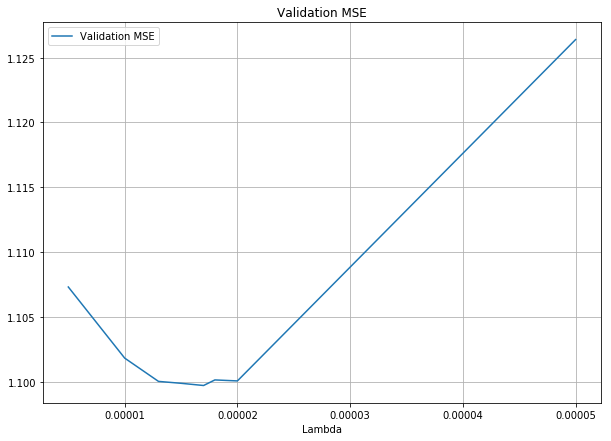

In [25]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))

plt.xlabel('Lambda')
plt.title('Validation MSE')
plt.grid(True)

plt.plot(lamb_values, MSE_valid, label='Validation MSE')

plt.legend()
plt.show()

In [24]:
best_theta

array([ 3.81233938,  0.3113362 ,  0.46095858, ..., -0.3010043 ,
       -0.01805242, -0.26187858])

In [26]:
### Rating baseline: compute averages for each user, or return 
### the global average if we've never seen the user before

predictions = open("assignment1/predictions_Rating.txt", 'w')
unpack(best_theta)

for l in open("assignment1/pairs_Rating.txt"):
  # write header  
  if l.startswith("userID"):
    predictions.write(l)
    continue
    
  # write user-item-rating
  u,b = l.strip().split('-')
  predictions.write(u + '-' + b + ',' + str(prediction(u,b)) + '\n')

predictions.close()

In [27]:
alpha = ratingMean

userBiases = defaultdict(float)
itemBiases = defaultdict(float)

userGamma = {}
itemGamma = {}

K = 1

# Initialize user and item Gammas
for u in ratingsPerUser:
    userGamma[u] = [random.random() * 0.1 - 0.05 for k in range(K)]
for i in ratingsPerItem:
    itemGamma[i] = [random.random() * 0.1 - 0.05 for k in range(K)]

In [28]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

def unpack(theta):
    global alpha
    global userBiases
    global itemBiases
    global userGamma
    global itemGamma
    index = 0
    alpha = theta[index]
    index += 1
    userBiases = dict(zip(users, theta[index:index+nUsers]))
    index += nUsers
    itemBiases = dict(zip(items, theta[index:index+nItems]))
    index += nItems
    for u in users:
        userGamma[u] = theta[index:index+K]
        index += K
    for i in items:
        itemGamma[i] = theta[index:index+K]
        index += K
        
def inner(x, y):
    return sum([a*b for a,b in zip(x,y)])

def prediction(user, item):
    return alpha + userBiases[user] + itemBiases[item] + inner(userGamma[user], itemGamma[item])

   
def cost(theta, labels, lamb):
    unpack(theta)
    predictions = [prediction(user, book) for user,book in Xtrain]
    cost = MSE(predictions, labels)
    print("MSE = " + str(cost))
    for u in users:
        cost += lamb*userBiases[u]**2
        for k in range(K):
            cost += lamb*userGamma[u][k]**2
    for i in items:
        cost += lamb*itemBiases[i]**2
        for k in range(K):
            cost += lamb*itemGamma[i][k]**2
    return cost


def derivative(theta, labels, lamb):
    unpack(theta)
    N = len(dataset)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dItemBiases = defaultdict(float)
    dUserGamma = {}
    dItemGamma = {}
    for u in ratingsPerUser:
        dUserGamma[u] = [0.0 for k in range(K)]
    for i in ratingsPerItem:
        dItemGamma[i] = [0.0 for k in range(K)]
    for value in zip(Xtrain,ytrain):
        x,rating = value
        u = x[0]
        i = x[1]
        pred = prediction(u, i)
        diff = pred - rating
        dalpha += 2/N*diff
        dUserBiases[u] += 2/N*diff
        dItemBiases[i] += 2/N*diff
        for k in range(K):
            dUserGamma[u][k] += 2/N*itemGamma[i][k]*diff
            dItemGamma[i][k] += 2/N*userGamma[u][k]*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
        for k in range(K):
            dUserGamma[u][k] += 2*lamb*userGamma[u][k]
    for i in itemBiases:
        dItemBiases[i] += 2*lamb*itemBiases[i]
        for k in range(K):
            dItemGamma[i][k] += 2*lamb*itemGamma[i][k]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
    for u in users:
        dtheta += dUserGamma[u]
    for i in items:
        dtheta += dItemGamma[i]
    return numpy.array(dtheta)

In [29]:
lamb_values = [1e-4, 8e-5, 6e-5, 5e-5, 4e-5, 3e-5, 2e-5, 1e-5]
MSE_valid =[]
thetas=[]
best_theta = []
best_MSE = 0

for lamb in lamb_values:
    print("Lambda = {}".format(lamb))
  
    theta_init = [alpha] + [0.0]*(nUsers+nItems) +  \
            [random.random() * 0.1 - 0.05 for k in range(K*(nUsers+nItems))]
    unpack(theta_init)
    
    def cost(theta, labels, lamb):
        unpack(theta)
        predictions = [prediction(user, book) for user,book in Xtrain]
        cost = MSE(predictions, labels)
        print("MSE = " + str(cost))
        for u in users:
            cost += lamb*userBiases[u]**2
            for k in range(K):
                cost += lamb*userGamma[u][k]**2
        for i in items:
            cost += lamb*itemBiases[i]**2
            for k in range(K):
                cost += lamb*itemGamma[i][k]**2
        return cost

    def derivative(theta, labels, lamb):
        unpack(theta)
        N = len(dataset)
        dalpha = 0
        dUserBiases = defaultdict(float)
        dItemBiases = defaultdict(float)
        dUserGamma = {}
        dItemGamma = {}
        for u in ratingsPerUser:
            dUserGamma[u] = [0.0 for k in range(K)]
        for i in ratingsPerItem:
            dItemGamma[i] = [0.0 for k in range(K)]
        for value in zip(Xtrain,ytrain):
            x,rating = value
            u = x[0]
            i = x[1]
            pred = prediction(u, i)
            diff = pred - rating
            dalpha += 2/N*diff
            dUserBiases[u] += 2/N*diff
            dItemBiases[i] += 2/N*diff
            for k in range(K):
                dUserGamma[u][k] += 2/N*itemGamma[i][k]*diff
                dItemGamma[i][k] += 2/N*userGamma[u][k]*diff
        for u in userBiases:
            dUserBiases[u] += 2*lamb*userBiases[u]
            for k in range(K):
                dUserGamma[u][k] += 2*lamb*userGamma[u][k]
        for i in itemBiases:
            dItemBiases[i] += 2*lamb*itemBiases[i]
            for k in range(K):
                dItemGamma[i][k] += 2*lamb*itemGamma[i][k]
        dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
        for u in users:
            dtheta += dUserGamma[u]
        for i in items:
            dtheta += dItemGamma[i]
        return numpy.array(dtheta)
    
    theta,_,_ = scipy.optimize.fmin_l_bfgs_b(cost, theta_init, derivative, args = (ytrain, lamb))
    thetas.append(theta)  # save thetas

    unpack(theta)
    predictions = [prediction(user, book) for user,book in Xvalid]
    cost = MSE(predictions, yvalid)
    
    if best_MSE is 0:
        best_MSE = cost
        best_theta = theta
        print("Save best theta...")
    else:
        if cost < best_MSE:
            best_MSE = cost
            best_theta = theta
            print("Save best theta...")
    
    MSE_valid.append(cost)
    print(cost)

Lambda = 0.0001
MSE = 1.472911714464408
MSE = 1.4555257179723937
MSE = 1.3919639784789475
MSE = 7.490819683692902
MSE = 1.376739341545793
MSE = 1.2204798698615391
MSE = 1.218624237734379
MSE = 1.211367353215079
MSE = 1.1849901152863394
MSE = 1.0959368812255847
MSE = 1.0763647182868918
MSE = 1.0639778627822707
MSE = 1.0646558928619114
MSE = 1.0653861842715504
MSE = 1.0645559180032453
MSE = 1.0635716123352426
MSE = 1.063520431831953
MSE = 1.064112002933143
MSE = 1.063545660268213
MSE = 1.0635222496589456
MSE = 1.0635205667898529
MSE = 1.0635204418734128
MSE = 1.0635204325792058
MSE = 1.0635204318876086
MSE = 1.0635204318360503
MSE = 1.0635204318322693
MSE = 1.0635204318322953
MSE = 1.0635204318342046
MSE = 1.0635204318324025
MSE = 1.063520431832299
MSE = 1.0635204318322953
Save best theta...
1.1775359456991676
Lambda = 8e-05
MSE = 1.476119044755357
MSE = 2.3379034429529293
MSE = 1.472791016758991
MSE = 1.4725847660744202
MSE = 1.4720051472399327
MSE = 1.4705350695072075
MSE = 1.466688117

MSE = 1.0755826536727273
MSE = 1.064329163914763
MSE = 1.0459837725756636
MSE = 1.0264969843614045
MSE = 1.0318745364152961
MSE = 1.0272989867652491
MSE = 1.0269275848184884
MSE = 1.0128956860437517
MSE = 1.011448653415465
MSE = 1.008924831963294
MSE = 1.0043755410997557
MSE = 1.0204616478382984
MSE = 1.0060045724344557
MSE = 1.0041767290391173
MSE = 0.9966446756779305
MSE = 0.994257001788545
MSE = 0.9935237754136971
MSE = 0.9940148315645186
MSE = 0.9946703221290986
MSE = 0.9952191086694048
MSE = 0.9956543269167126
MSE = 1.001204375742941
MSE = 0.9953873843464361
MSE = 0.9939895061598008
MSE = 0.9907717704898347
MSE = 0.9896108641437549
MSE = 0.9884742721900621
MSE = 0.9877533668737032
MSE = 1.1181419652324187
MSE = 0.9876005975426527
MSE = 0.9877715887676483
MSE = 0.9892533410685949
MSE = 0.9881362146679821
MSE = 0.9902859920172785
MSE = 0.9884264611126778
MSE = 0.9884870671825574
MSE = 0.9883218371742423
MSE = 1.0015371746649422
MSE = 0.9883138502855044
MSE = 0.9876978935705786
MSE =

MSE = 0.9170057946779203
MSE = 0.9162376545275299
MSE = 0.91450882320836
MSE = 0.8950190269023306
MSE = 0.9086502577825432
MSE = 0.909068951479074
MSE = 0.9088098129966606
MSE = 0.9089679080349716
MSE = 0.9087998766392931
MSE = 0.9081875343910999
MSE = 0.9070125909552779
MSE = 0.9063289623135159
MSE = 0.9038696422650696
MSE = 0.9054282962532146
MSE = 0.906608545605546
MSE = 0.9056674985256213
MSE = 0.9059335481625073
MSE = 0.9060669037556501
MSE = 0.9061577910255978
MSE = 0.9059417163286224
MSE = 0.9075279164282988
MSE = 0.9057096767353222
MSE = 0.9048199155898777
MSE = 0.903607990628909
MSE = 0.9029395521262881
MSE = 0.9028035709619533
MSE = 0.9026951043453832
MSE = 0.9021823485513939
MSE = 1.1643824958205886
MSE = 0.9022408843387715
MSE = 0.9013647071620187
MSE = 0.8942106219150132
MSE = 0.8985093159338395
MSE = 0.8983643693722195
MSE = 0.8980775785935566
MSE = 0.8974979295039172
MSE = 0.8976465622763516
MSE = 0.897580344034824
MSE = 0.8974843500963314
MSE = 0.8974220195531337
MSE = 

MSE = 0.8585964470123668
MSE = 0.8569704340515758
MSE = 0.8529107140973115
MSE = 0.8549433884808229
MSE = 0.8544046378971571
MSE = 0.8527513277514053
MSE = 0.8487485247848395
MSE = 0.8509424682967276
MSE = 0.848856656726996
MSE = 0.849396890321369
MSE = 0.9424481667120903
MSE = 0.850033511897837
MSE = 0.8495170202427994
MSE = 0.8462082052799454
MSE = 0.8458012040307595
MSE = 0.8440596209997014
MSE = 0.8445041994547856
MSE = 0.8439252591303092
MSE = 0.8442123151422326
MSE = 0.8447481616592483
MSE = 0.8452808952540861
MSE = 0.8467239340213041
MSE = 0.8455176308786582
MSE = 0.846349735916283
MSE = 0.845949684109099
MSE = 0.8455227441242865
MSE = 0.8448138505641233
MSE = 0.8442061030273547
MSE = 0.8431387941374671
MSE = 0.8432321205772354
MSE = 0.843057941364262
MSE = 0.8423814947577712
MSE = 0.8424894994014707
MSE = 0.8429451140883399
MSE = 0.8444615278282847
MSE = 0.8430780993864094
MSE = 0.8435527798003968
MSE = 0.8429775995122187
MSE = 0.8432165448026745
MSE = 0.843605025344151
MSE = 0

MSE = 0.8283960024157585
MSE = 0.9172021408359706
MSE = 0.8272573240987943
MSE = 0.8263063453814898
MSE = 0.825043291851139
MSE = 0.825257605326523
MSE = 0.8347147350787698
MSE = 0.8260234414909252
MSE = 0.8221730573868835
MSE = 0.8212654580055114
MSE = 0.8204637650502777
MSE = 0.821503884887902
MSE = 0.8214571887082184
MSE = 0.8213369394955304
MSE = 0.8222893039657382
MSE = 0.8230427272835671
MSE = 0.8232554013849219
MSE = 0.839008151974039
MSE = 0.8236292945591295
MSE = 0.822186445688762
MSE = 0.957427333142911
MSE = 0.822345914946513
MSE = 0.8195916292739747
MSE = 0.8192500798832865
MSE = 0.8193450037371821
MSE = 0.8179092469022592
MSE = 0.8180791317308784
MSE = 0.817820476921967
MSE = 0.8179925103766029
MSE = 0.8181847090186192
MSE = 0.818481499373656
MSE = 0.8187797325752159
MSE = 0.8187998219756946
MSE = 0.8180680734356542
MSE = 8.257795888758272
MSE = 0.8179406989120317
MSE = 0.8163096519581409
MSE = 0.8149502814502254
MSE = 0.8144973511034558
MSE = 0.8143919656717177
MSE = 0.81

MSE = 1.4595824051087134
MSE = 1.4397500587976888
MSE = 1.3958808607770867
MSE = 1.3201442179703786
MSE = 1.238900997949577
MSE = 1.199979607059792
MSE = 1.1943816447484816
MSE = 1.1943200713684774
MSE = 1.1939628952474237
MSE = 1.1904788023338346
MSE = 1.1816416607218894
MSE = 1.1596152235876558
MSE = 1.1217657399697962
MSE = 1.0814962650911468
MSE = 1.0606819246884762
MSE = 10.998205444381815
MSE = 1.0570501462267918
MSE = 1.0552037913433439
MSE = 1.0535158122587651
MSE = 1.0445794390613892
MSE = 1.0242352002403134
MSE = 0.9997590593104911
MSE = 0.9822145219235967
MSE = 0.9710048923998245
MSE = 0.966822833445079
MSE = 0.9602826893960739
MSE = 0.9504815259330631
MSE = 4.63473515414855
MSE = 0.9480860404693756
MSE = 0.9447420140428063
MSE = 0.9438585983366932
MSE = 0.9412432217640337
MSE = 0.939259803445872
MSE = 0.9339069739382438
MSE = 0.9274463531232949
MSE = 0.9262053217040933
MSE = 0.925145692871793
MSE = 0.9523044579794122
MSE = 0.9239233075045008
MSE = 0.9225338803367421
MSE = 0

MSE = 0.7365990466393793
MSE = 0.7285722906808718
MSE = 0.7287755322378261
MSE = 0.7283643840437146
MSE = 0.7280864000680667
MSE = 0.7282006146160144
MSE = 0.7280554916028112
MSE = 0.7278948172034228
MSE = 0.7279161372098909
MSE = 0.7283592734165195
MSE = 0.7287388073895867
MSE = 0.7956188506385735
MSE = 0.7287617793193003
MSE = 0.7290820105964395
MSE = 0.7291529465902408
MSE = 0.7290382723648698
MSE = 0.728666515167056
MSE = 0.7286351922814971
MSE = 0.7284692761407716
MSE = 0.7279506956873092
MSE = 0.7273027354909901
MSE = 0.7266995863371288
MSE = 0.7263446932713524
MSE = 0.7262414295582665
MSE = 0.7261495013544863
MSE = 0.7258339263108953
MSE = 0.7256499924540827
MSE = 0.7252610623393204
MSE = 0.726585713991451
MSE = 0.7252988989386829
MSE = 0.7240553717687174
MSE = 0.7234254164425031
MSE = 0.7230992545853282
MSE = 0.723140441847862
MSE = 0.7230407579231628
MSE = 0.7290950939549644
MSE = 0.7231899306204719
MSE = 0.7232441594345794
MSE = 0.7232905472334579
MSE = 0.7231928716769518
MSE

MSE = 0.7125437363547896
MSE = 0.7125002551050066
MSE = 0.7124973546313075
MSE = 0.712510934540091
MSE = 0.7125361272593422
MSE = 0.7125384734380659
MSE = 0.7181373651051655
MSE = 0.7125736149313169
MSE = 0.7125871017479672
MSE = 0.7126347340217359
MSE = 0.7125951720126529
MSE = 0.7125874253326114
MSE = 0.7125809026435281
MSE = 0.7125624554872824
MSE = 0.712663025823218
MSE = 0.7125669583629339
MSE = 0.7125604413755442
MSE = 0.7125647757106316
MSE = 0.7125813794626209
MSE = 0.712605835404076
MSE = 0.7125835755229981
MSE = 0.7125728882555419
MSE = 0.7125639761276387
MSE = 0.7125359919739824
MSE = 0.7125798485228243
MSE = 0.7125112086969089
MSE = 0.7124774057296223
MSE = 0.7124197155425187
MSE = 0.7124304075624152
MSE = 0.7124111220763961
MSE = 0.7123747494617391
MSE = 0.7123751494868648
MSE = 0.7123784657322524
MSE = 0.7123740957232341
MSE = 0.7128203100912216
MSE = 0.7123684091461245
MSE = 0.7123586132364019
MSE = 0.712316629808848
MSE = 0.7122038008646362
MSE = 0.7134938773240527
MSE 

MSE = 0.7101298082159404
MSE = 0.7101298082108485
MSE = 0.7101298082142109
MSE = 0.7101298082115223
MSE = 0.710129808210916
MSE = 0.7101298082108485
1.293056691437069


In [16]:
for lamb, MSE in zip(lamb_values ,MSE_valid):
    print ("Lamb-{} gives MSE of {}".format(lamb, MSE))

Lamb-0.0001 gives MSE of 1.1195637405724344
Lamb-8e-05 gives MSE of 1.1013907720554
Lamb-6e-05 gives MSE of 1.0807068634356816
Lamb-5e-05 gives MSE of 1.071115508630035
Lamb-4e-05 gives MSE of 1.062854458948445
Lamb-3e-05 gives MSE of 1.0518645992698112
Lamb-2e-05 gives MSE of 1.1310767507029222
Lamb-1e-05 gives MSE of 1.2187399719836565


In [17]:
### Rating baseline: compute averages for each user, or return 
### the global average if we've never seen the user before

predictions = open("assignment1/predictions_Rating.txt", 'w')
unpack(best_theta)

for l in open("assignment1/pairs_Rating.txt"):
  # write header  
  if l.startswith("userID"):
    predictions.write(l)
    continue
    
  # write user-item-rating
  u,b = l.strip().split('-')
  predictions.write(u + '-' + b + ',' + str(prediction(u,b)) + '\n')

predictions.close()